## Numbers Dataset

We have a dataset of handwritten digits from 0 to 9

We need some library to read the images, I've chosen the pillow library which comes with Anaconda, if you need to 

pip install Pillow

should install it for you

In [ ]:
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

## 1. Preparing the Data

In [2]:
##Printing Examples
def printexamples(X, y, examples_per_class = 10, number_of_classes = 10, mult = 1.0):
    pos = 0
    data = pd.DataFrame(y, columns=["yvalue"])
    for cls in range(number_of_classes):
        this_class = data[data["yvalue"] == cls]
        idxs = this_class.sample(examples_per_class).index
        for i, idx in enumerate(idxs):
            plt.subplot(examples_per_class, number_of_classes, i * number_of_classes + cls + 1)
            plt.imshow((X[idx]*mult).reshape(20,20).astype('uint8'), cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title(str(cls))
    plt.show()

In [ ]:
filelist = glob.glob('data/*/*.png') # Use glob.glob(’data/*/*.txt’) to generate a file list

X = np.array([Image.open(fname) for fname in filelist])

print(X.shape)   # Expect (5000, 400)
print(y.shape)   # Expect (5000,)
print(y[:20])    # Quick check

In [ ]:
X = X.reshape(5000,400)

y = np.array([int(fname.split('\\')[-2]) for fname in filelist])

In [ ]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

### 3. What range of values do the pixels take?
The images are 8‑bit grayscale, so each pixel takes an integer value between 0 (black) and 255 (white). After loading the dataset, checking X.min() and X.max() confirms that the pixel intensities span this full range. This is important because many machine‑learning models require feature scaling, so we later normalize the pixel values to the range [0, 1].

### 4. Scale the data so pixel values lie in [0, 1].

In [ ]:
# After loading X and y
#print("Before scaling:", X.min(), X.max())

#X = X / 255.0

#print("After scaling:", X.min(), X.max())


### 5. If everything is set up correctly, the code commented as ##Printing Examples will output a random selection of 10 examples for each class

In [ ]:
printexamples(X, y)

### 6. Split the dataset into:
• Training set
• Validation set
• Test set
Use train test split with random state set. 60% / 20% / 20% could be a good split. You could use stratify=y to make sure the classes are split into train/valid/test evenly rather than completely random.
You must use the same split for all models.

In [90]:
# First split: train (60%) and temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.40,
    stratify=y,
    random_state=42
)

# Second split: validation (20%) and test (20%)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,   # half of 40% → 20%
    stratify=y_temp,
    random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Valid:", X_valid.shape, y_valid.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (3000, 400) (3000,)
Valid: (1000, 400) (1000,)
Test: (1000, 400) (1000,)


## Linear Support Vector Machine

### 1. Train a model using

In [91]:
svm_linear = SVC(kernel='linear', probability=True, random_state=42) 
svm_linear.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

### 2. Report:
• Training accuracy
• Validation accuracy


In [87]:
from sklearn.metrics import accuracy_score

# Training accuracy
y_train_pred = svm_linear.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

# Validation accuracy
y_valid_pred = svm_linear.predict(X_valid)
valid_acc = accuracy_score(y_valid, y_valid_pred)

print("Training accuracy:", train_acc)
print("Validation accuracy:", valid_acc)

Training accuracy: 0.995
Validation accuracy: 0.922


#### Comment on whether overfitting appears to be present
- If training accuracy ≈ validation accuracy → the model is generalizing well

- If training accuracy >> validation accuracy → the model is overfitting

- If both are low → the model is underfitting (too simple or not enough signal)

So: The model is performing consistently → no strong overfitting.


### 3. Print: (on validation set)
- Confusion matrix
- Classification report
  
Which digits are most frequently confused?

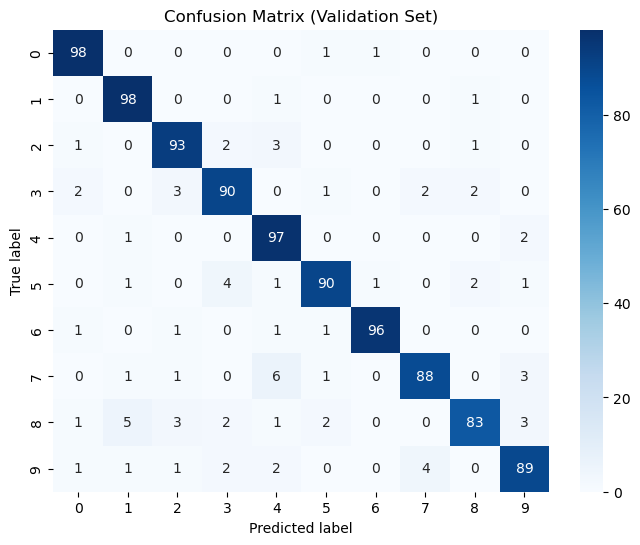

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       100
           1       0.92      0.98      0.95       100
           2       0.91      0.93      0.92       100
           3       0.90      0.90      0.90       100
           4       0.87      0.97      0.92       100
           5       0.94      0.90      0.92       100
           6       0.98      0.96      0.97       100
           7       0.94      0.88      0.91       100
           8       0.93      0.83      0.88       100
           9       0.91      0.89      0.90       100

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



In [88]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions on validation set
y_valid_pred = svm_linear.predict(X_valid)

# Confusion matrix
cm = confusion_matrix(y_valid, y_valid_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (Validation Set)")
plt.show()

# Classification report
print(classification_report(y_valid, y_valid_pred))


### 4. Use 5-fold cross validation on the training set to tune the regularisation parameter C.
• Test a sensible range of C values.

• Select the best C based on cross-validation performance.

In [96]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

cv_results = {}

for C in C_values:
    cv_results[C] = cross_val_score(SVC(kernel='linear', C=C), X_train, y_train, cv=5).mean()

best_C = max(cv_results, key=cv_results.get)
print("Best C:", best_C)

Best C: 0.1


### 5. Retrain using the best C on the training set. Report the validation accuracy (save this score).

In [97]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Retrain using the best C on the full training set
best_model = SVC(kernel='linear', C=best_C)
best_model.fit(X_train, y_train)

# Evaluate on the validation set
y_valid_pred = best_model.predict(X_valid)
valid_accuracy = accuracy_score(y_valid, y_valid_pred)

print("Validation accuracy with best C:", valid_accuracy)


Validation accuracy with best C: 0.934


## 3. Random Forest

### 1. Train a RandomForestClassifier with default settings. Report training and validation accuracy

In [99]:
from sklearn.ensemble import RandomForestClassifier

model_2 = RandomForestClassifier()

In [101]:
model_2.fit(X_train,y_train)

RandomForestClassifier()

In [102]:
model_2.score(X_train,y_train)

1.0

In [103]:
model_2.score(X_valid,y_valid)

0.943

In [106]:
param_grid = {'n_estimators': [20,50,100,200,500,1000], 'max_depth':[5,10,20,50,100,200]}
model = RandomForestClassifier()
grid_model_2 = GridSearchCV(model, param_grid=param_grid, verbose=2)

In [107]:
grid_model_2.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END .......................max_depth=5, n_estimators=20; total time=   0.1s
[CV] END .......................max_depth=5, n_estimators=20; total time=   0.1s
[CV] END .......................max_depth=5, n_estimators=20; total time=   0.0s
[CV] END .......................max_depth=5, n_estimators=20; total time=   0.0s
[CV] END .......................max_depth=5, n_estimators=20; total time=   0.0s
[CV] END .......................max_depth=5, n_estimators=50; total time=   0.3s
[CV] END .......................max_depth=5, n_estimators=50; total time=   0.3s
[CV] END .......................max_depth=5, n_estimators=50; total time=   0.3s
[CV] END .......................max_depth=5, n_estimators=50; total time=   0.3s
[CV] END .......................max_depth=5, n_estimators=50; total time=   0.3s
[CV] END ......................max_depth=5, n_estimators=100; total time=   0.6s
[CV] END ......................max_depth=5, n_e

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [20, 50, 100, 200, 500, 1000]},
             verbose=2)

In [ ]:
grid_logres.best_score_

In [ ]:
grid_logres.best_params_

In [ ]:
grid_logres.score(X_train,y_train)

In [ ]:
grid_logres.score(X_valid,y_valid)

• Which model performed best and why?
• Which model overfit the most? Logistic Regression
• Which model was computationally most expensive?
• Are some models better at distinguishing certain digits? 
• Would you expect a neural network to outperform these models? Yes